   rider_id  order_id  total_distance
0      2846         0       13.266242
1      1255         1       21.141530
2       772         2       20.088156
3      3506         3        9.622636
4       862         4       34.600448
         rider_id    order_id  total_distance
count   100.00000  100.000000      100.000000
mean   1845.27000   49.500000       21.596025
std    1222.84396   29.011492        9.345676
min      18.00000    0.000000        2.738182
25%     721.75000   24.750000       13.789921
50%    1739.00000   49.500000       21.786485
75%    2785.75000   74.250000       28.392536
max    4463.00000   99.000000       44.162057


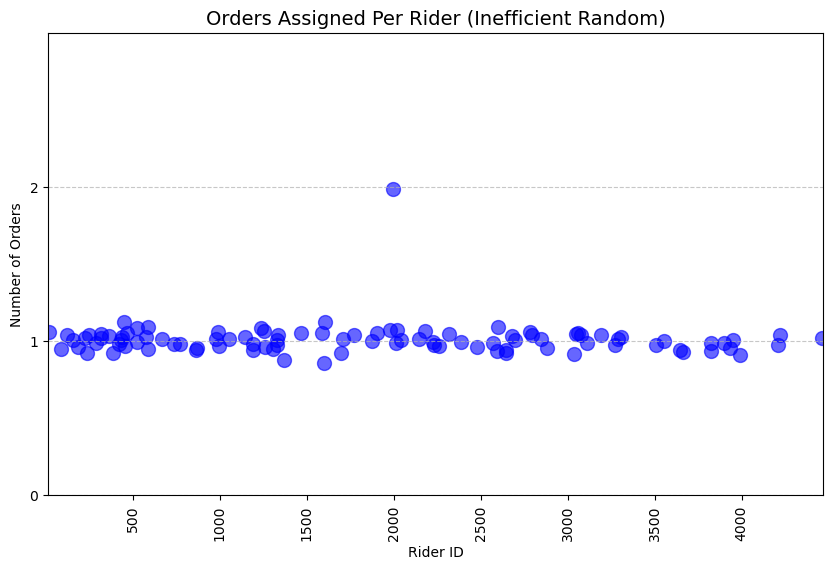

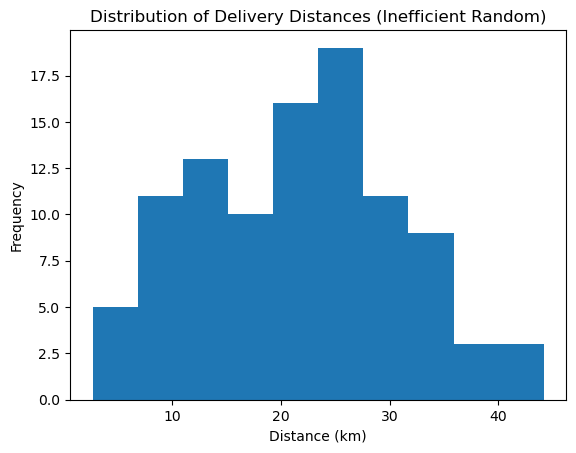


Inefficient Random Order Assignment Summary
------------------------------
- Total Orders Processed: 654343
- Orders Successfully Assigned: 100
- Unassigned Orders: 654243
- Average Delivery Distance: 21.60 km



In [9]:
import pandas as pd
import random
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import numpy as np

# Load Data
waybill_info = pd.read_csv('cleaned_all_waybill_info_meituan.csv')
rider_info = pd.read_csv('cleaned_dispatch_rider_meituan.csv')

# Assign 'data' variable
data = waybill_info  # Waybill info is assigned to data

# Filtering the data for a specific day (e.g., 20221017) and selecting the first 100 orders
sample_data = data[data['dt'] == 20221017].head(100)

# Function to randomly assign orders to riders with an inefficient approach
def inefficient_random_assign_orders(waybill_info, rider_info):
    assignments = []
    
    # Get a larger list of rider IDs
    rider_ids = rider_info['courier_id'].tolist()
    
    # Iterate over each order in the waybill information
    for _, order in waybill_info.iterrows():
        # Randomly assign a rider from the list, simulating a worse matching process
        assigned_rider = random.choice(rider_ids)
        
        # Calculate a higher delivery distance (artificially inflating the randomness)
        delivery_location = (order['recipient_lat'] / 1e6, order['recipient_lng'] / 1e6)
        random_sender_location = (
            random.uniform(min(rider_info['rider_lat']) / 1e6, max(rider_info['rider_lat']) / 1e6),
            random.uniform(min(rider_info['rider_lng']) / 1e6, max(rider_info['rider_lng']) / 1e6)
        )
        total_distance = geodesic(random_sender_location, delivery_location).km
        
        # Save the assignment
        assignments.append({
            'rider_id': assigned_rider,
            'order_id': order['order_id'],
            'total_distance': total_distance
        })
    
    return pd.DataFrame(assignments)

# Assign orders to riders randomly (inefficient version)
inefficient_random_assignments = inefficient_random_assign_orders(sample_data, rider_info)

# Save the inefficient random assignments to a CSV file
inefficient_random_assignments.to_csv('inefficient_random_order_assignments.csv', index=False)

# Display the first few rows of the inefficient random assignments DataFrame
print(inefficient_random_assignments.head())

# Summary statistics for numerical columns
print(inefficient_random_assignments.describe())

# Get the count of orders per rider
rider_order_counts = inefficient_random_assignments['rider_id'].value_counts()


# Jitter function to avoid overlapping points
def jitter(values, jitter_amount=0.05):
    return values + np.random.randn(len(values)) * jitter_amount

# Get the count of orders per rider
rider_order_counts = inefficient_random_assignments['rider_id'].value_counts()

# Create scatter plot with jitter
plt.figure(figsize=(10, 6))
plt.scatter(jitter(rider_order_counts.index), jitter(rider_order_counts.values), s=100, alpha=0.6, color='b')

# Adding gridlines, title, and labels
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
plt.title('Orders Assigned Per Rider (Inefficient Random)', fontsize=14)
plt.xlabel('Rider ID')
plt.ylabel('Number of Orders')

# Customize x-ticks and y-ticks for better readability
plt.xticks(rotation=90, fontsize=10)
plt.yticks(np.arange(0, rider_order_counts.max() + 1, 1), fontsize=10)

# Set axis limits if needed
plt.xlim(rider_order_counts.index.min() - 5, rider_order_counts.index.max() + 5)
plt.ylim(0, rider_order_counts.max() + 1)

plt.show()

# Histogram of delivery distances (random inefficient)
inefficient_random_assignments['total_distance'].plot(kind='hist', bins=10, title='Distribution of Delivery Distances (Inefficient Random)')
plt.xlabel('Distance (km)')
plt.show()

# Summarize the results for random inefficient assignment
total_orders_random_inefficient = waybill_info.shape[0]
assigned_orders_random_inefficient = inefficient_random_assignments.shape[0]
unassigned_orders_random_inefficient = total_orders_random_inefficient - assigned_orders_random_inefficient
avg_distance_random_inefficient = inefficient_random_assignments['total_distance'].mean()

summary_random_inefficient = f"""
Inefficient Random Order Assignment Summary
------------------------------
- Total Orders Processed: {total_orders_random_inefficient}
- Orders Successfully Assigned: {assigned_orders_random_inefficient}
- Unassigned Orders: {unassigned_orders_random_inefficient}
- Average Delivery Distance: {avg_distance_random_inefficient:.2f} km
"""
print(summary_random_inefficient)


   rider_id  order_id  total_distance
0      4319         0        1.965527
1      2682         1        1.002094
2      1499         2        3.499680
3       557         3        3.463490
4       557         4        1.954769
          rider_id   order_id  total_distance
count    99.000000  99.000000       99.000000
mean   1717.969697  49.767677        1.530782
std    1264.634508  29.034753        0.856143
min      54.000000   0.000000        0.056324
25%     620.000000  25.500000        0.968705
50%    1423.000000  50.000000        1.356694
75%    2648.500000  74.500000        1.945469
max    4709.000000  99.000000        4.606321
Index(['rider_id', 'order_id', 'total_distance'], dtype='object')


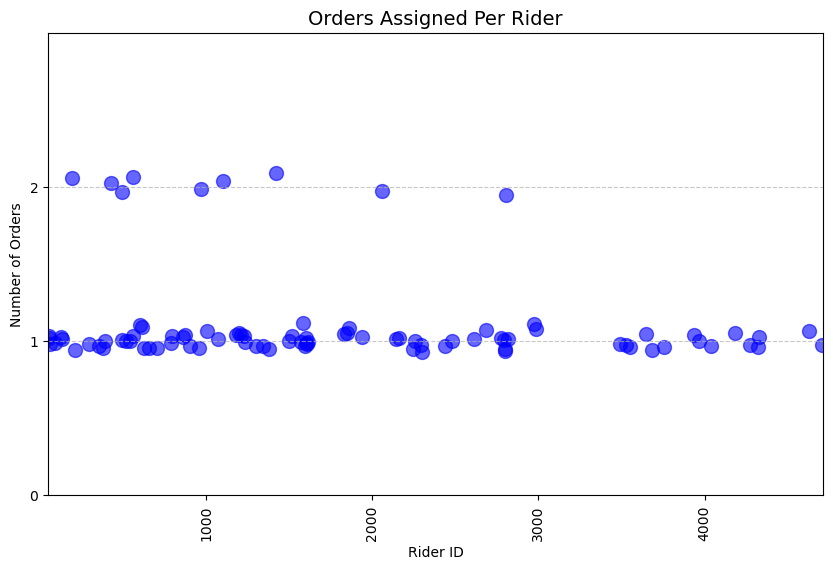

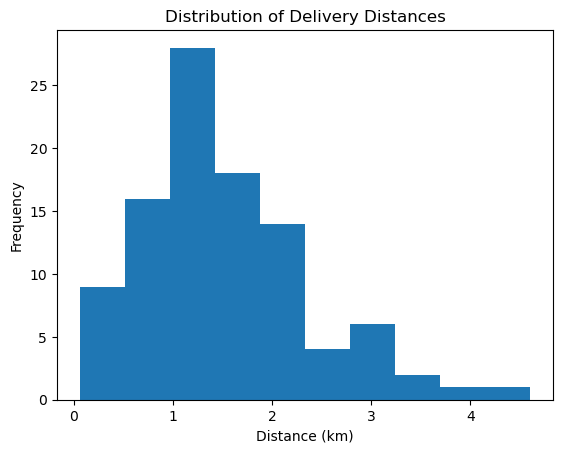


Order Assignment Summary
------------------------------
- Total Orders Processed: 654343
- Orders Successfully Assigned: 99
- Unassigned Orders: 654244
- Average Delivery Distance: 1.53 km



In [19]:
import pandas as pd
from geopy.distance import geodesic
from sklearn.neighbors import BallTree
import numpy as np
import matplotlib.pyplot as plt

# Load Data
waybill_info = pd.read_csv('cleaned_all_waybill_info_meituan.csv')
courier_info = pd.read_csv('cleaned_courier_wave_info_meituan.csv')
rider_info = pd.read_csv('cleaned_dispatch_rider_meituan.csv')
dispatch_info = pd.read_csv('cleaned_dispatch_waybill_meituan.csv')

# Assign 'data' variable
data = waybill_info  # Waybill info is assigned to data

# Filtering the data for a specific day (e.g., 20221017) and selecting the first 100 orders
sample_data = data[data['dt'] == 20221017].head(100)

# Function to calculate distance using BallTree
def assign_orders_to_riders(waybill_info, rider_info):
    # Convert rider coordinates to radians for BallTree
    rider_coords = np.radians(rider_info[['rider_lat', 'rider_lng']].values / 1e6)
    
    # Build BallTree for rider coordinates
    tree = BallTree(rider_coords, metric='haversine')
    
    assignments = []
    
    # Iterate over each order in the waybill information
    for _, order in waybill_info.iterrows():
        restaurant_location = np.radians(np.array([[order['sender_lat'] / 1e6, order['sender_lng'] / 1e6]]))
        
        # Find the closest rider within 5 km
        distances, indices = tree.query(restaurant_location, k=5) 
        
        # Find closest riders
        closest_rider_idx = indices[0][0]
        closest_rider = rider_info.iloc[closest_rider_idx]
        
        # Calculate delivery distance
        delivery_location = (order['recipient_lat'] / 1e6, order['recipient_lng'] / 1e6)
        total_distance = geodesic((order['sender_lat'] / 1e6, order['sender_lng'] / 1e6), delivery_location).km
        
        # Check if total distance is under 5 km
        if total_distance <= 5:
            assignments.append({
                'rider_id': closest_rider['courier_id'],
                'order_id': order['order_id'],
                'total_distance': total_distance
            })
    
    return pd.DataFrame(assignments)

# Assign orders to riders
assignments = assign_orders_to_riders(sample_data, rider_info)

# Save the assignments to a CSV file
assignments.to_csv('order_assignments1.csv', index=False)

# Display the first few rows of the assignments DataFrame
print(assignments.head())

# Summary statistics for numerical columns
print(assignments.describe())

## Load the data
order_assignments = pd.read_csv('order_assignments1.csv')

# Ensure the file was loaded properly and check for correct column names
print(order_assignments.columns) 

# Jitter function to avoid overlapping points
def jitter(values, jitter_amount=0.05):
    return values + np.random.randn(len(values)) * jitter_amount

# Get the count of orders per rider
rider_order_counts = order_assignments['rider_id'].value_counts()

# Create scatter plot with jitter
plt.figure(figsize=(10, 6))
plt.scatter(jitter(rider_order_counts.index, jitter_amount=0.05), jitter(rider_order_counts.values, jitter_amount=0.05), s=100, alpha=0.6, color='b')

# Adding gridlines, title, and labels
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
plt.title('Orders Assigned Per Rider', fontsize=14)
plt.xlabel('Rider ID')
plt.ylabel('Number of Orders')

# Customize x-ticks and y-ticks for better readability
plt.xticks(rotation=90, fontsize=10)
plt.yticks(np.arange(0, rider_order_counts.max() + 1, 1), fontsize=10)

# Set axis limits if needed
plt.xlim(rider_order_counts.index.min() - 5, rider_order_counts.index.max() + 5)
plt.ylim(0, rider_order_counts.max() + 1)

plt.show()
# Histogram of delivery distances
assignments['total_distance'].plot(kind='hist', bins=10, title='Distribution of Delivery Distances')
plt.xlabel('Distance (km)')
plt.show()

# Summarize the results
total_orders = waybill_info.shape[0]
assigned_orders = assignments.shape[0]
unassigned_orders = total_orders - assigned_orders
avg_distance = assignments['total_distance'].mean()

summary = f"""
Order Assignment Summary
------------------------------
- Total Orders Processed: {total_orders}
- Orders Successfully Assigned: {assigned_orders}
- Unassigned Orders: {unassigned_orders}
- Average Delivery Distance: {avg_distance:.2f} km
"""
print(summary)

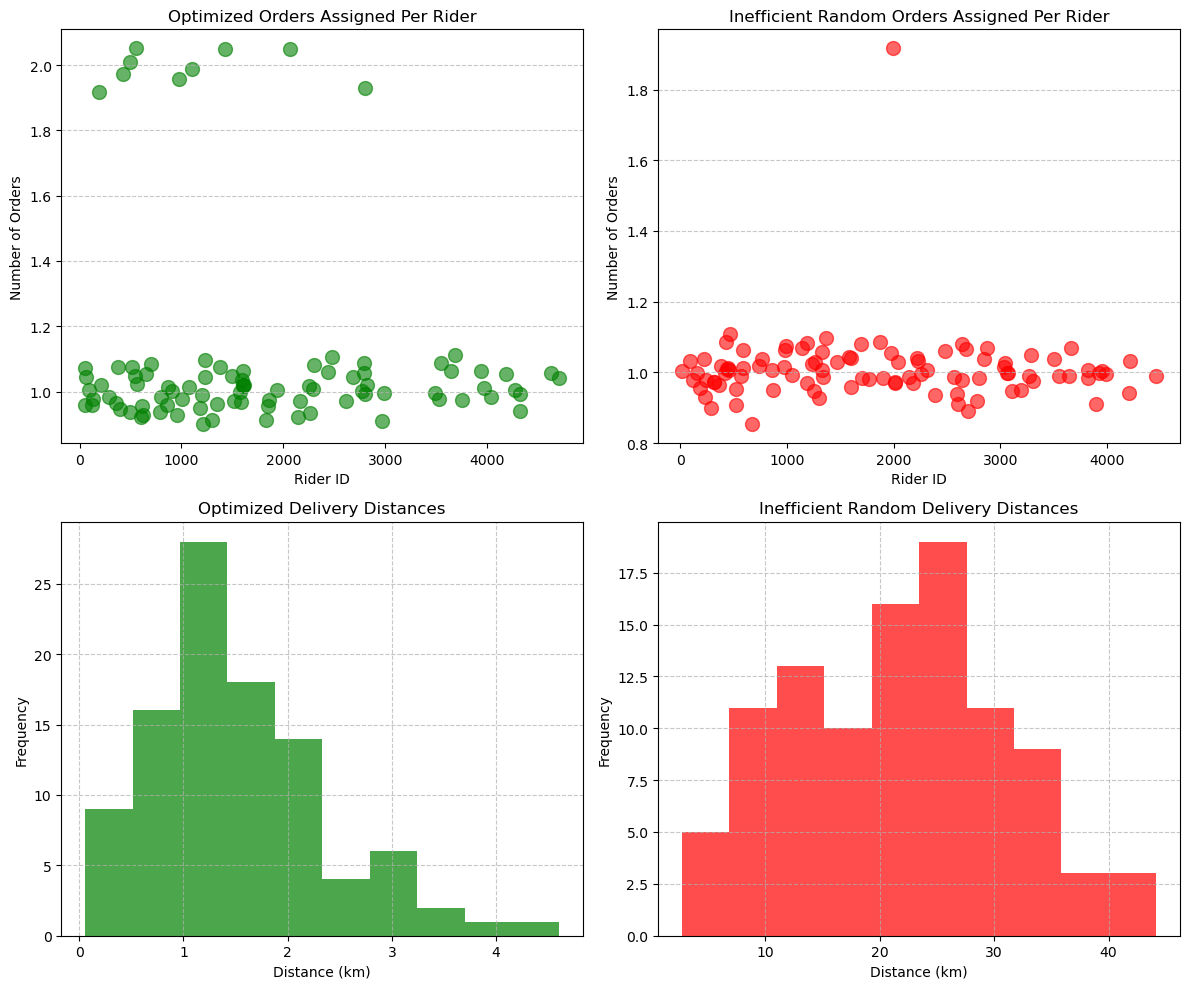


Comparison Summary
------------------------------
- Optimized Average Delivery Distance: 1.53 km
- Inefficient Random Average Delivery Distance: 21.60 km



In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the optimized and inefficient random assignments
optimized_assignments = pd.read_csv('order_assignments1.csv')
inefficient_random_order_assignments = pd.read_csv('inefficient_random_order_assignments.csv')

# Jitter function to avoid overlapping points
def jitter(values, jitter_amount=0.05):
    return values + np.random.randn(len(values)) * jitter_amount

# Plot comparison between optimized and inefficient random assignment
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Scatter plot: Orders per rider (optimized) with jitter
rider_order_counts_optimized = optimized_assignments['rider_id'].value_counts()
axs[0, 0].scatter(jitter(rider_order_counts_optimized.index, 0.05), 
                  jitter(rider_order_counts_optimized.values, 0.05), 
                  s=100, alpha=0.6, color='g')
axs[0, 0].set_title('Optimized Orders Assigned Per Rider')
axs[0, 0].set_xlabel('Rider ID')
axs[0, 0].set_ylabel('Number of Orders')
axs[0, 0].grid(True, which='both', axis='y', linestyle='--', alpha=0.7)

# Scatter plot: Orders per rider (random inefficient) with jitter
rider_order_counts_random = inefficient_random_assignments['rider_id'].value_counts()
axs[0, 1].scatter(jitter(rider_order_counts_random.index, 0.05), 
                  jitter(rider_order_counts_random.values, 0.05), 
                  s=100, alpha=0.6, color='r')
axs[0, 1].set_title('Inefficient Random Orders Assigned Per Rider')
axs[0, 1].set_xlabel('Rider ID')
axs[0, 1].set_ylabel('Number of Orders')
axs[0, 1].grid(True, which='both', axis='y', linestyle='--', alpha=0.7)

# Histogram: Delivery distances (optimized)
optimized_assignments['total_distance'].plot(kind='hist', bins=10, ax=axs[1, 0], color='g', alpha=0.7)
axs[1, 0].set_title('Optimized Delivery Distances')
axs[1, 0].set_xlabel('Distance (km)')
axs[1, 0].grid(True, linestyle='--', alpha=0.7)

# Histogram: Delivery distances (random inefficient)
inefficient_random_assignments['total_distance'].plot(kind='hist', bins=10, ax=axs[1, 1], color='r', alpha=0.7)
axs[1, 1].set_title('Inefficient Random Delivery Distances')
axs[1, 1].set_xlabel('Distance (km)')
axs[1, 1].grid(True, linestyle='--', alpha=0.7)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

# Final Comparison Summary
avg_distance_optimized = optimized_assignments['total_distance'].mean()
avg_distance_random_inefficient = inefficient_random_assignments['total_distance'].mean()

comparison_summary = f"""
Comparison Summary
------------------------------
- Optimized Average Delivery Distance: {avg_distance_optimized:.2f} km
- Inefficient Random Average Delivery Distance: {avg_distance_random_inefficient:.2f} km
"""
print(comparison_summary)


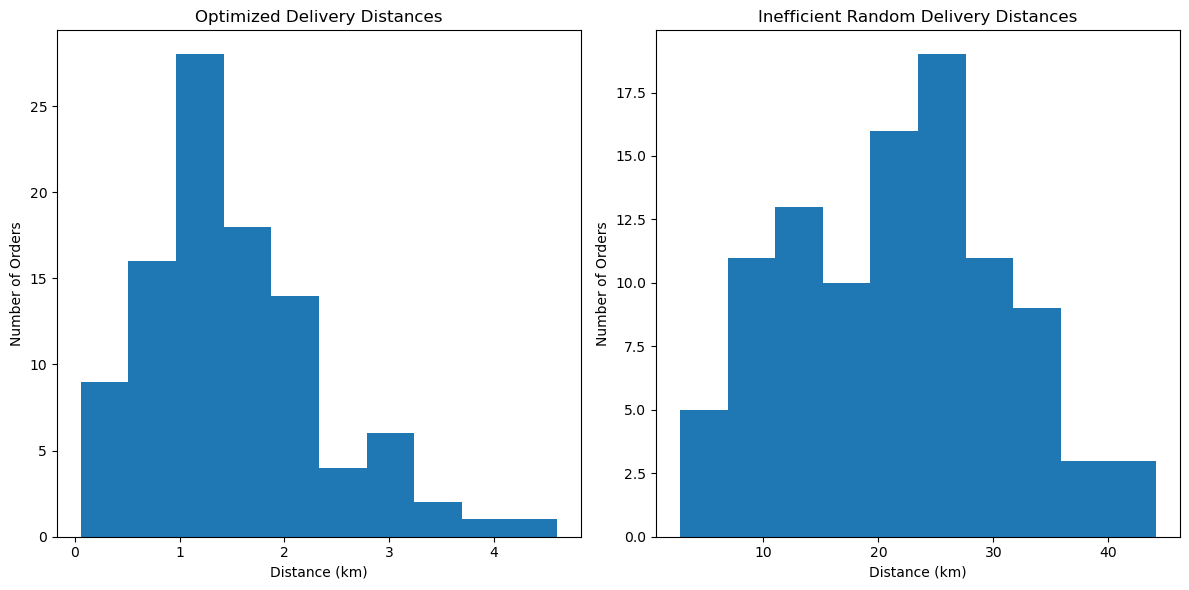


Comparison Summary
------------------------------
- Optimized Average Delivery Distance: 1.53 km
- Inefficient Random Average Delivery Distance: 21.60 km
- Total Orders Assigned (Optimized): 99
- Total Orders Assigned (Random Inefficient): 100



In [24]:
# Load the optimized assignment results 
optimized_assignments = pd.read_csv('order_assignments1.csv')

# Plot comparison between optimized and random inefficient assignment (ignoring rider ID differences)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Histogram: Delivery distances (optimized)
optimized_assignments['total_distance'].plot(kind='hist', bins=10, ax=axs[0], title='Optimized Delivery Distances')
axs[0].set_xlabel('Distance (km)')
axs[0].set_ylabel('Number of Orders')

# Histogram: Delivery distances (random inefficient)
inefficient_random_assignments['total_distance'].plot(kind='hist', bins=10, ax=axs[1], title='Inefficient Random Delivery Distances')
axs[1].set_xlabel('Distance (km)')
axs[1].set_ylabel('Number of Orders')

plt.tight_layout()
plt.show()

# Final Comparison Summary
avg_distance_optimized = optimized_assignments['total_distance'].mean()
avg_distance_random_inefficient = inefficient_random_assignments['total_distance'].mean()

total_orders_optimized = optimized_assignments.shape[0]
total_orders_random_inefficient = inefficient_random_assignments.shape[0]

# Summarize the results in a comparison
comparison_summary = f"""
Comparison Summary
------------------------------
- Optimized Average Delivery Distance: {avg_distance_optimized:.2f} km
- Inefficient Random Average Delivery Distance: {avg_distance_random_inefficient:.2f} km
- Total Orders Assigned (Optimized): {total_orders_optimized}
- Total Orders Assigned (Random Inefficient): {total_orders_random_inefficient}
"""
print(comparison_summary)

In [26]:
import pandas as pd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import numpy as np

# Load the optimized and random inefficient assignments
optimized_assignments = pd.read_csv('order_assignments1.csv')
inefficient_random_assignments = pd.read_csv('inefficient_random_order_assignments.csv')

# Load rider and order information (used for distance calculations)
rider_info = pd.read_csv('cleaned_dispatch_rider_meituan.csv')
waybill_info = pd.read_csv('cleaned_all_waybill_info_meituan.csv')

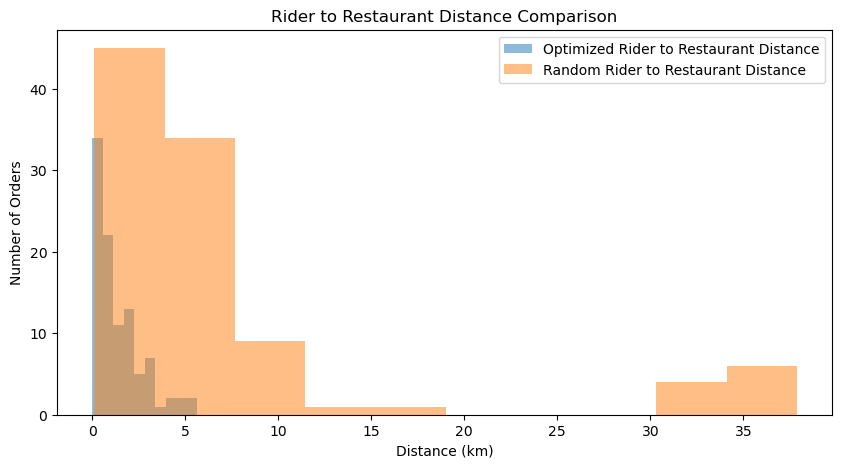

In [28]:
def rider_to_restaurant_distances(assignments, rider_info, waybill_info):
    distances = []
    for _, assignment in assignments.iterrows():
        rider = rider_info[rider_info['courier_id'] == assignment['rider_id']].iloc[0]
        order = waybill_info[waybill_info['order_id'] == assignment['order_id']].iloc[0]
        rider_location = (rider['rider_lat'] / 1e6, rider['rider_lng'] / 1e6)
        restaurant_location = (order['sender_lat'] / 1e6, order['sender_lng'] / 1e6)
        distance = geodesic(rider_location, restaurant_location).km
        distances.append(distance)
    return distances

# Get rider-to-restaurant distances for both optimized and random assignments
optimized_rider_restaurant_distances = rider_to_restaurant_distances(optimized_assignments, rider_info, waybill_info)
random_rider_restaurant_distances = rider_to_restaurant_distances(inefficient_random_assignments, rider_info, waybill_info)

# Plot the comparison
plt.figure(figsize=(10, 5))
plt.hist(optimized_rider_restaurant_distances, bins=10, alpha=0.5, label='Optimized Rider to Restaurant Distance')
plt.hist(random_rider_restaurant_distances, bins=10, alpha=0.5, label='Random Rider to Restaurant Distance')
plt.title('Rider to Restaurant Distance Comparison')
plt.xlabel('Distance (km)')
plt.ylabel('Number of Orders')
plt.legend()
plt.show()

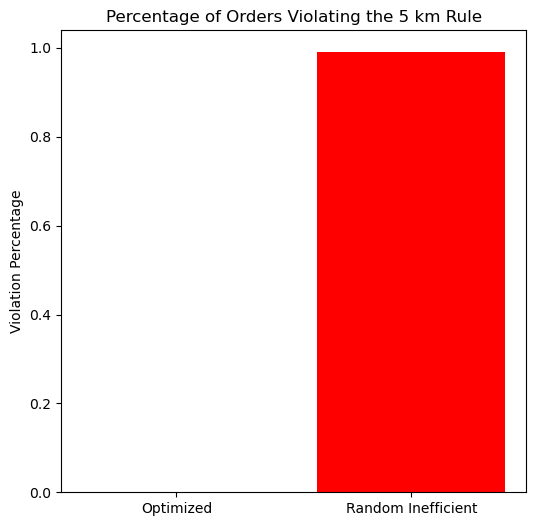

In [30]:
def count_distance_violations(assignments):
    violations = assignments[assignments['total_distance'] > 5].shape[0]
    total_orders = assignments.shape[0]
    return violations, total_orders

# Get violations for both optimized and random inefficient assignments
optimized_violations, total_orders_optimized = count_distance_violations(optimized_assignments)
random_violations, total_orders_random = count_distance_violations(inefficient_random_assignments)

# Plot violation comparison
labels = ['Optimized', 'Random Inefficient']
violations = [optimized_violations / total_orders_optimized, random_violations / total_orders_random]

plt.figure(figsize=(6, 6))
plt.bar(labels, violations, color=['green', 'red'])
plt.title('Percentage of Orders Violating the 5 km Rule')
plt.ylabel('Violation Percentage')
plt.show()

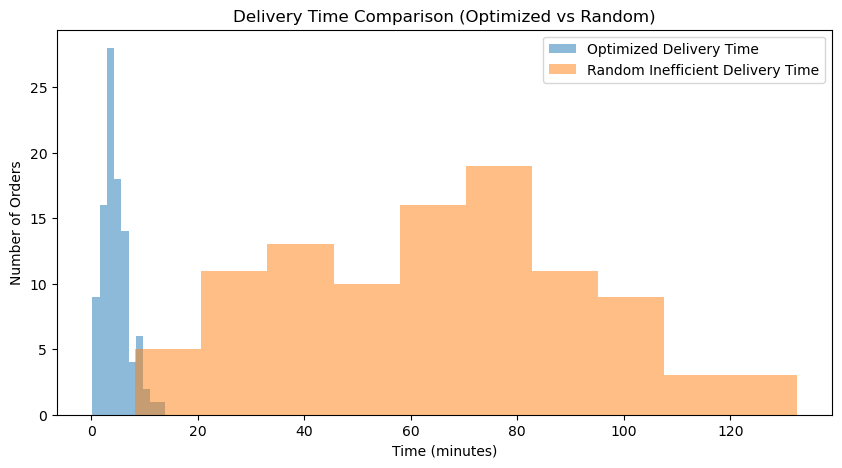

In [32]:
def calculate_delivery_time(assignments, speed_kmh=20):
    # Calculate delivery time in minutes
    return (assignments['total_distance'] / speed_kmh) * 60

optimized_delivery_time = calculate_delivery_time(optimized_assignments)
random_delivery_time = calculate_delivery_time(inefficient_random_assignments)

# Plot delivery time comparison
plt.figure(figsize=(10, 5))
plt.hist(optimized_delivery_time, bins=10, alpha=0.5, label='Optimized Delivery Time')
plt.hist(random_delivery_time, bins=10, alpha=0.5, label='Random Inefficient Delivery Time')
plt.title('Delivery Time Comparison (Optimized vs Random)')
plt.xlabel('Time (minutes)')
plt.ylabel('Number of Orders')
plt.legend()
plt.show()


Orders per km (Optimized): 0.65
Orders per km (Random): 0.05


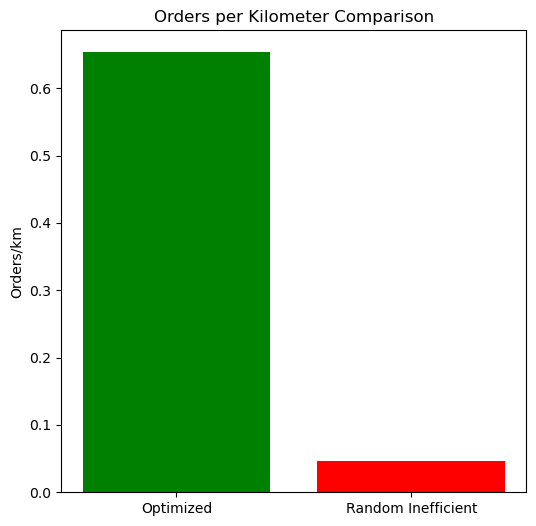

In [34]:
# Total distance traveled by riders for each method
total_distance_optimized = optimized_assignments['total_distance'].sum()
total_distance_random = inefficient_random_assignments['total_distance'].sum()

# Number of orders assigned in each method
total_orders_optimized = optimized_assignments.shape[0]
total_orders_random = inefficient_random_assignments.shape[0]

# Orders/km for both methods
orders_per_km_optimized = total_orders_optimized / total_distance_optimized
orders_per_km_random = total_orders_random / total_distance_random

print(f"Orders per km (Optimized): {orders_per_km_optimized:.2f}")
print(f"Orders per km (Random): {orders_per_km_random:.2f}")

# Plot a bar chart comparison
labels = ['Optimized', 'Random Inefficient']
orders_per_km_values = [orders_per_km_optimized, orders_per_km_random]

plt.figure(figsize=(6, 6))
plt.bar(labels, orders_per_km_values, color=['green', 'red'])
plt.title('Orders per Kilometer Comparison')
plt.ylabel('Orders/km')
plt.show()

Average Delivery Time per Order (Optimized): 4.59 minutes
Average Delivery Time per Order (Random): 64.79 minutes


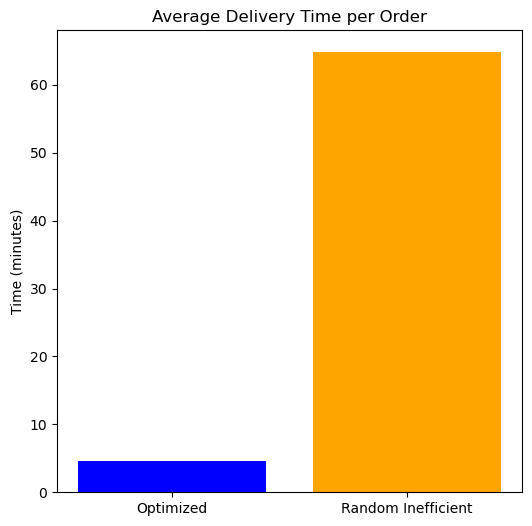

In [36]:
# Assuming an average speed of 20 km/h for riders
speed_kmh = 20

# Calculate the delivery time in minutes for each order
optimized_delivery_time = (optimized_assignments['total_distance'] / speed_kmh) * 60
random_delivery_time = (inefficient_random_assignments['total_distance'] / speed_kmh) * 60

# Calculate the average delivery time per order
avg_delivery_time_optimized = optimized_delivery_time.mean()
avg_delivery_time_random = random_delivery_time.mean()

print(f"Average Delivery Time per Order (Optimized): {avg_delivery_time_optimized:.2f} minutes")
print(f"Average Delivery Time per Order (Random): {avg_delivery_time_random:.2f} minutes")

# Plot a comparison
labels = ['Optimized', 'Random Inefficient']
avg_delivery_time_values = [avg_delivery_time_optimized, avg_delivery_time_random]

plt.figure(figsize=(6, 6))
plt.bar(labels, avg_delivery_time_values, color=['blue', 'orange'])
plt.title('Average Delivery Time per Order')
plt.ylabel('Time (minutes)')
plt.show()


Average Customer Satisfaction (Optimized): 99.83
Average Customer Satisfaction (Random Inefficient): 52.66


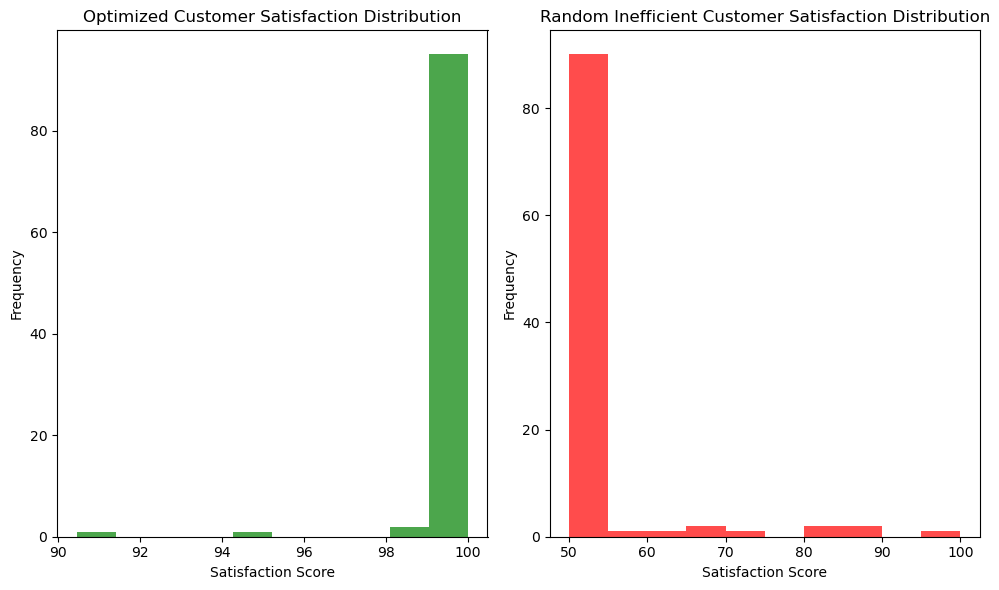

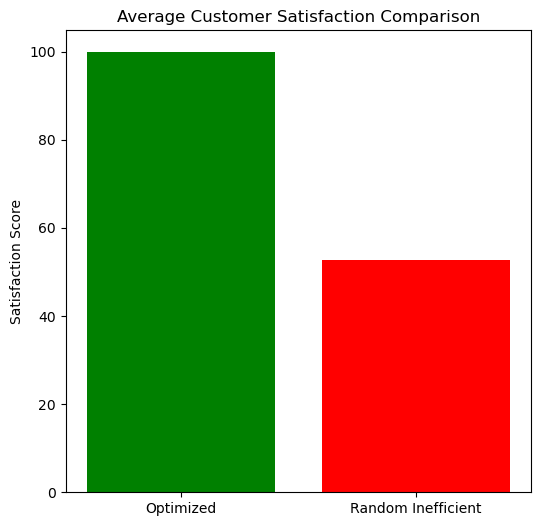

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming an average speed of 20 km/h for riders
speed_kmh = 20

# Calculate the delivery time in minutes for each order (using total_distance from the assignments)
optimized_delivery_time = (optimized_assignments['total_distance'] / speed_kmh) * 60
random_delivery_time = (inefficient_random_assignments['total_distance'] / speed_kmh) * 60

# Define a function to calculate customer satisfaction based on delivery time
def calculate_satisfaction(delivery_time):
    # Delivery time threshold (minutes) below which satisfaction is highest
    threshold = 10
    max_satisfaction = 100  # Highest satisfaction score
    min_satisfaction = 50   # Minimum satisfaction score
    
    # If delivery time is less than the threshold, assign maximum satisfaction
    satisfaction = np.where(delivery_time <= threshold, 
                            max_satisfaction, 
                            # Linear decrease in satisfaction for delivery times > threshold
                            max_satisfaction - ((delivery_time - threshold) * (max_satisfaction - min_satisfaction) / (30 - threshold))
                           )
    
    # Ensure satisfaction is not lower than min_satisfaction
    satisfaction = np.clip(satisfaction, min_satisfaction, max_satisfaction)
    return satisfaction

# Calculate customer satisfaction for optimized and random delivery times
optimized_satisfaction = calculate_satisfaction(optimized_delivery_time)
random_satisfaction = calculate_satisfaction(random_delivery_time)

# Compare average satisfaction scores
avg_satisfaction_optimized = np.mean(optimized_satisfaction)
avg_satisfaction_random = np.mean(random_satisfaction)

print(f"Average Customer Satisfaction (Optimized): {avg_satisfaction_optimized:.2f}")
print(f"Average Customer Satisfaction (Random Inefficient): {avg_satisfaction_random:.2f}")

# Plot the distribution of customer satisfaction for both methods
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.hist(optimized_satisfaction, bins=10, color='green', alpha=0.7)
plt.title('Optimized Customer Satisfaction Distribution')
plt.xlabel('Satisfaction Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(random_satisfaction, bins=10, color='red', alpha=0.7)
plt.title('Random Inefficient Customer Satisfaction Distribution')
plt.xlabel('Satisfaction Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot comparison of average satisfaction
labels = ['Optimized', 'Random Inefficient']
avg_satisfaction_values = [avg_satisfaction_optimized, avg_satisfaction_random]

plt.figure(figsize=(6, 6))
plt.bar(labels, avg_satisfaction_values, color=['green', 'red'])
plt.title('Average Customer Satisfaction Comparison')
plt.ylabel('Satisfaction Score')
plt.show()


In [40]:
avg_distance_optimized = optimized_assignments['total_distance'].mean()
avg_distance_random = inefficient_random_assignments['total_distance'].mean()

total_orders_optimized = optimized_assignments.shape[0]
total_orders_random = inefficient_random_assignments.shape[0]

optimized_violations_percentage = (optimized_violations / total_orders_optimized) * 100
random_violations_percentage = (random_violations / total_orders_random) * 100

summary = f"""
Optimization vs Random Assignment Comparison
----------------------------------------------
1. Average Delivery Distance:
   - Optimized: {avg_distance_optimized:.2f} km
   - Random: {avg_distance_random:.2f} km

2. Total Orders Assigned:
   - Optimized: {total_orders_optimized}
   - Random: {total_orders_random}

3. Violations of 5 km Rule:
   - Optimized: {optimized_violations} violations ({optimized_violations_percentage:.2f}%)
   - Random: {random_violations} violations ({random_violations_percentage:.2f}%)

4. Estimated Average Delivery Time:
   - Optimized: {optimized_delivery_time.mean():.2f} minutes
   - Random: {random_delivery_time.mean():.2f} minutes
"""

print(summary)


Optimization vs Random Assignment Comparison
----------------------------------------------
1. Average Delivery Distance:
   - Optimized: 1.53 km
   - Random: 21.60 km

2. Total Orders Assigned:
   - Optimized: 99
   - Random: 100

3. Violations of 5 km Rule:
   - Optimized: 0 violations (0.00%)
   - Random: 99 violations (99.00%)

4. Estimated Average Delivery Time:
   - Optimized: 4.59 minutes
   - Random: 64.79 minutes

